<a href="https://colab.research.google.com/github/ashfaquekhowaja/Deep-Learning-Projects/blob/main/COVID-19%20Chest%20X-ray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [39]:
# from zipfile import ZipFile
#file_name = 'CovidDataset.zip'

#with ZipFile(file_name, 'r') as zip:
  #zip.extractall()
 # print('done') 

In [40]:
image_size = (299, 299)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory='/content/drive/MyDrive/CovidDataset/Train Data',
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory='/content/drive/MyDrive/CovidDataset/Test Data',
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 6480 files belonging to 2 classes.
Using 5184 files for training.
Found 720 files belonging to 2 classes.
Using 144 files for validation.


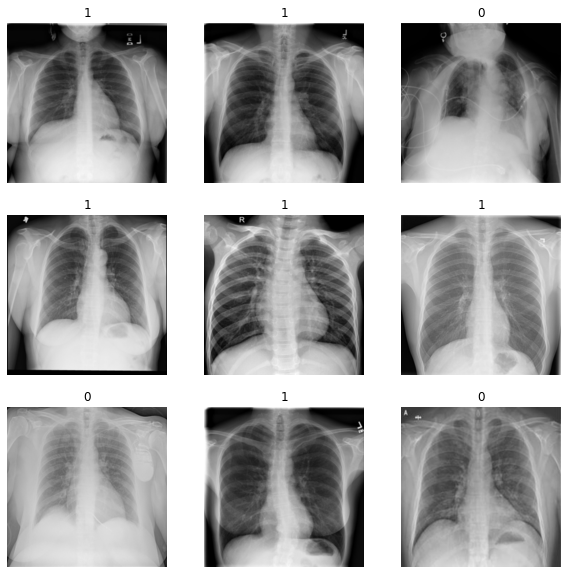

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [42]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

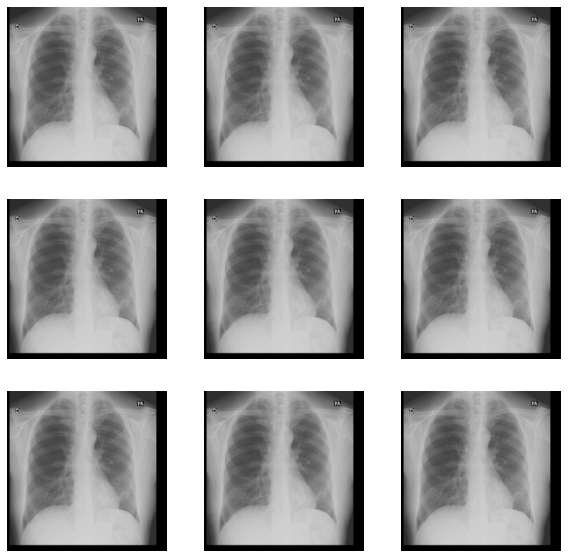

In [43]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [44]:
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

In [45]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

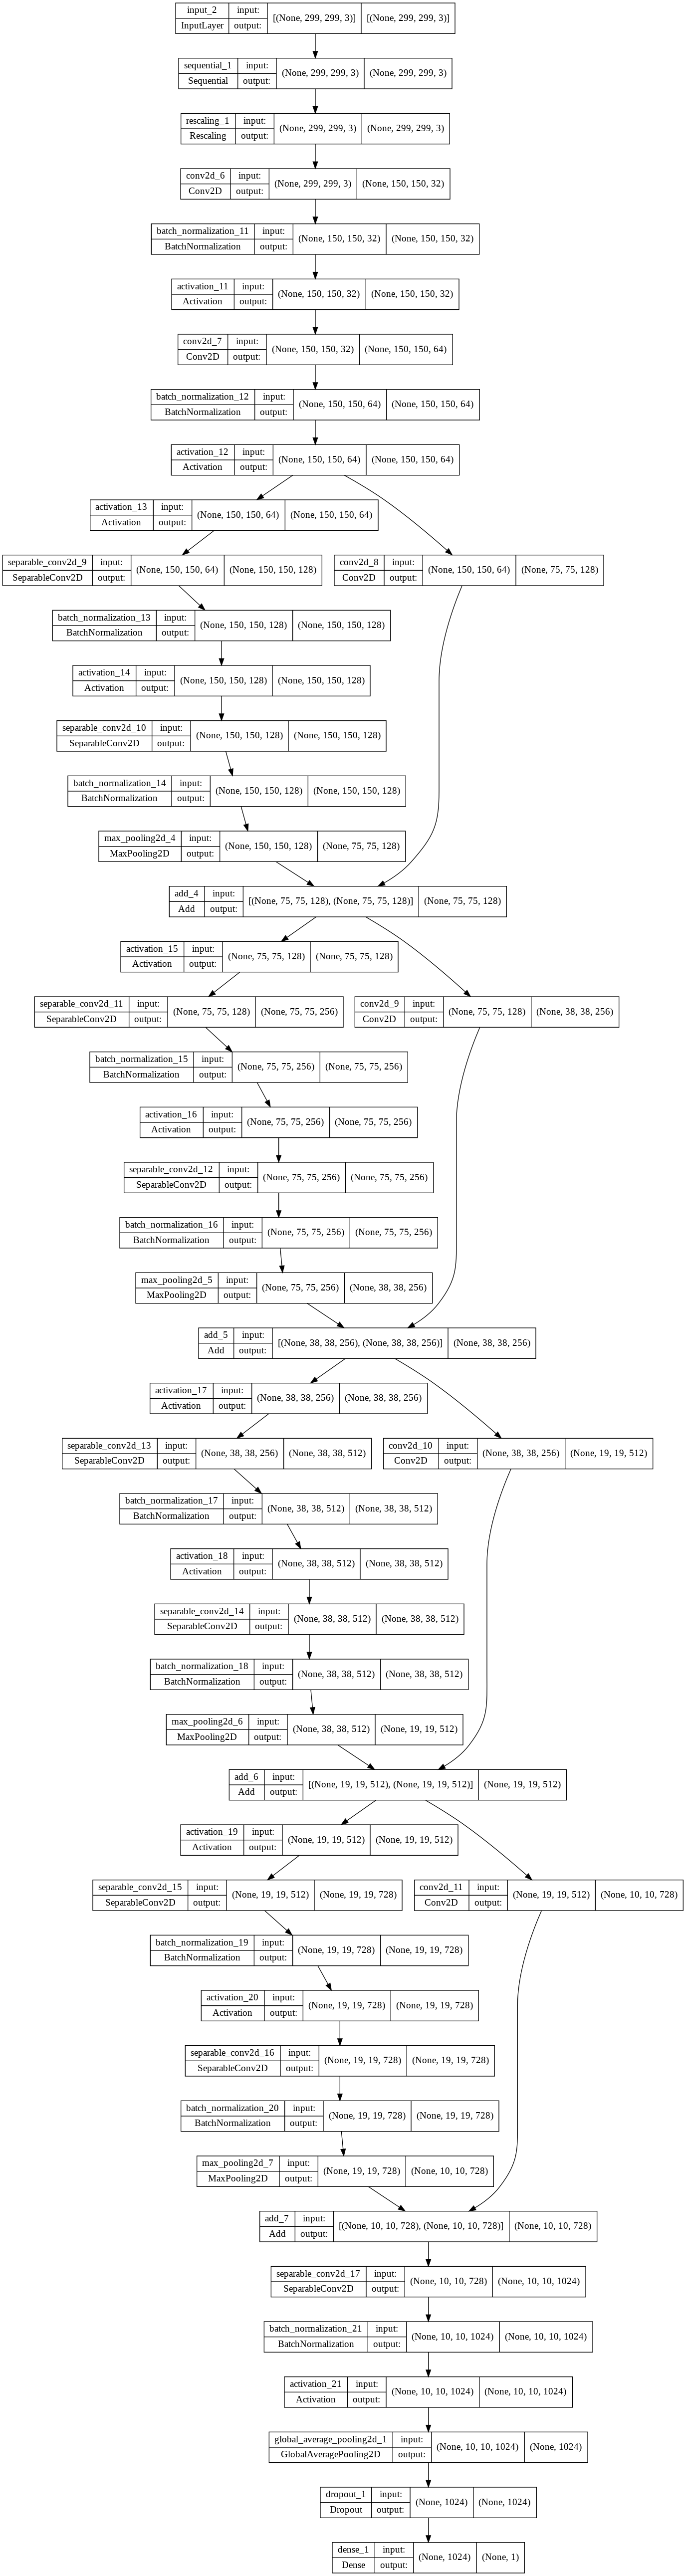

In [46]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [47]:
epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
history = model.fit(train_ds, epochs=epochs, validation_steps=2, callbacks=callbacks, validation_data=val_ds,)

Epoch 1/10
162/162 [==============================] - 114s 683ms/step - loss: 0.5221 - accuracy: 0.7564 - val_loss: 2.2655 - val_accuracy: 0.4219
Epoch 2/10
162/162 [==============================] - 113s 695ms/step - loss: 0.3800 - accuracy: 0.8378 - val_loss: 4.1468 - val_accuracy: 0.4375
Epoch 3/10
162/162 [==============================] - 114s 698ms/step - loss: 0.3241 - accuracy: 0.8586 - val_loss: 2.7159 - val_accuracy: 0.3750
Epoch 4/10
162/162 [==============================] - 113s 693ms/step - loss: 0.2822 - accuracy: 0.8841 - val_loss: 0.1453 - val_accuracy: 0.9688
Epoch 5/10
162/162 [==============================] - 112s 689ms/step - loss: 0.2369 - accuracy: 0.9062 - val_loss: 1.0150 - val_accuracy: 0.7656
Epoch 6/10
162/162 [==============================] - 113s 695ms/step - loss: 0.2216 - accuracy: 0.9145 - val_loss: 21.0429 - val_accuracy: 0.5469
Epoch 7/10
162/162 [==============================] - 113s 694ms/step - loss: 0.2061 - accuracy: 0.9159 - val_loss: 3.5689 

In [48]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential_1 (Sequential)      (None, 299, 299, 3)  0           ['input_2[0][0]']                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 299, 299, 3)  0           ['sequential_1[0][0]']           
                                                                                                  
 conv2d_6 (Conv2D)              (None, 150, 150, 32  896         ['rescaling_1[0][0]']      

In [49]:
model.save("model_adv.h5")

In [50]:
img = keras.preprocessing.image.load_img(
    "/content/drive/MyDrive/CovidDataset/Test Data/COVID/COVID-277.png", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent Covid patient image and %.2f percent normal patient."
    % (100 * (1 - score), 100 * score)
)

This image is 99.80 percent Covid patient image and 0.20 percent normal patient.


In [53]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


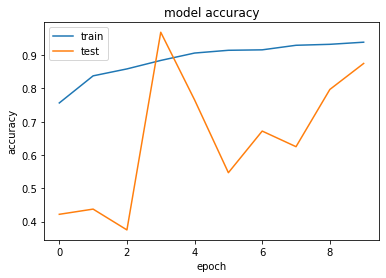

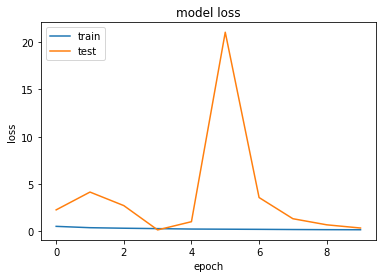

In [54]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [57]:
## Test iamges
model = keras.models.load_model('/content/model_adv.h5')

In [58]:
y_actual = []
y_test = []

In [59]:
import os

In [60]:
from keras.preprocessing import image
import numpy as np

In [61]:
for i in os.listdir('/content/drive/MyDrive/CovidDataset/Test Data/Normal/'):
  img = image.load_img('/content/drive/MyDrive/CovidDataset/Test Data/Normal/'+i, target_size=(299,299))
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  predict_x=model.predict(img)
  y_test.append(predict_x[0,0])
  y_actual.append(1)

In [62]:
for i in os.listdir('/content/drive/MyDrive/CovidDataset/Test Data/COVID/'):
  img = image.load_img('/content/drive/MyDrive/CovidDataset/Test Data/COVID/'+i, target_size=(299,299))
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  predict_x=model.predict(img)
  y_test.append(predict_x[0,0])
  y_actual.append(1)

In [63]:
print(y_actual)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [64]:
print(y_test)

[1.0, 1.0, 1.0, 0.99999917, 1.0, 0.9999939, 0.9999988, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999, 0.001416197, 0.9997589, 0.88134545, 0.99999905, 0.9999894, 0.99998784, 0.99998355, 0.9986926, 0.99626887, 0.97411877, 0.9975333, 0.9999999, 0.9999622, 1.0, 0.99881554, 0.99999976, 0.99998796, 0.9999963, 0.8953421, 1.0, 0.9948, 0.999982, 0.96723706, 0.99995077, 0.9999031, 0.9940587, 0.9915605, 0.99995065, 0.99999976, 0.9991025, 0.999992, 0.99996865, 0.9950139, 0.9999527, 0.9998392, 0.99999976, 0.9999999, 0.99999976, 0.9998294, 0.9272823, 0.99998534, 0.9999893, 0.21719982, 0.99999976, 0.9999918, 1.0, 0.9999738, 0.9999999, 0.5658562, 0.99098957, 0.9999982, 0.99999714, 0.99999976, 0.999972, 0.9999796, 0.99839103, 0.9927361, 1.0, 0.99987864, 0.99999976, 0.9856307, 0.9999974, 0.9999945, 0.99996877, 0.67663944, 0.9999995, 0.691781, 0.99999917, 0.99943143, 0.99999166, 0.9996735, 0.9997495, 0.981247, 0.9999976, 0.9999813, 0.9999995, 0.99791795, 0.8428759,

In [65]:
print(predict_x)

[[0.02719613]]


In [66]:
print(img)

[[[[ 12.  12.  12.]
   [ 12.  12.  12.]
   [ 12.  12.  12.]
   ...
   [ 65.  65.  65.]
   [109. 109. 109.]
   [112. 112. 112.]]

  [[  2.   2.   2.]
   [  2.   2.   2.]
   [  2.   2.   2.]
   ...
   [ 52.  52.  52.]
   [102. 102. 102.]
   [103. 103. 103.]]

  [[  0.   0.   0.]
   [  0.   0.   0.]
   [  0.   0.   0.]
   ...
   [ 48.  48.  48.]
   [ 98.  98.  98.]
   [ 99.  99.  99.]]

  ...

  [[ 67.  67.  67.]
   [ 53.  53.  53.]
   [ 49.  49.  49.]
   ...
   [  9.   9.   9.]
   [ 12.  12.  12.]
   [ 12.  12.  12.]]

  [[ 67.  67.  67.]
   [ 56.  56.  56.]
   [ 54.  54.  54.]
   ...
   [ 12.  12.  12.]
   [ 15.  15.  15.]
   [ 15.  15.  15.]]

  [[ 75.  75.  75.]
   [ 64.  64.  64.]
   [ 62.  62.  62.]
   ...
   [ 26.  26.  26.]
   [ 31.  31.  31.]
   [ 31.  31.  31.]]]]


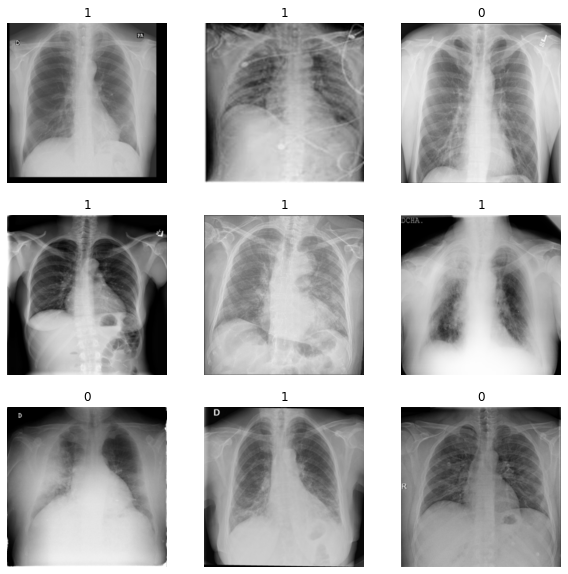

In [67]:
plt.figure(figsize=(10, 10))
for image in img:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

**Heat Map**

In [56]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [75]:
model_builder = keras.applications.xception.Xception
img_size = (299, 299)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = "block8_sepconv2_act"

Predicted: [('n03388043', 'fountain', 7.799004)]


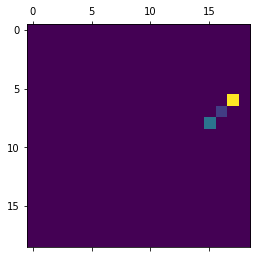

In [76]:
# Prepare image
img_array = preprocess_input(get_img_array("/content/drive/MyDrive/CovidDataset/Test Data/COVID/COVID-277.png", size=(299,299)))

# Make model
model = model_builder(weights="imagenet")

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

In [87]:
import matplotlib.cm as cm
from IPython.display import Image, display

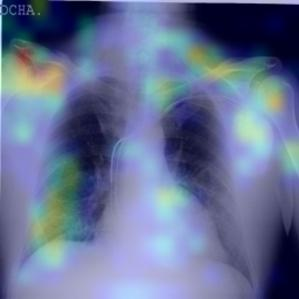

In [88]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam("/content/drive/MyDrive/CovidDataset/Test Data/COVID/COVID-277.png", heatmap)